In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# I created a small data for this assessment , data is small and imbalanced But
# Approach and method are best i use everything for model enhancement 

In [2]:
df = pd.read_csv('Input_Data.csv')

# EDA (EXPLORATORY DATA ANALYSIS)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   News Title  17 non-null     object
 1   Category    17 non-null     object
 2   Sentiment   17 non-null     object
 3   Aspect      17 non-null     object
dtypes: object(4)
memory usage: 676.0+ bytes


In [4]:
df.describe()

,News Title,Category,Sentiment,Aspect
count,17,17,17,17
unique,17,5,3,16
top,Most economical spells at T20 World Cup - Whic...,Politics,Positive,Economy
freq,1,8,8,2


# Step 2: Category Distribution

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

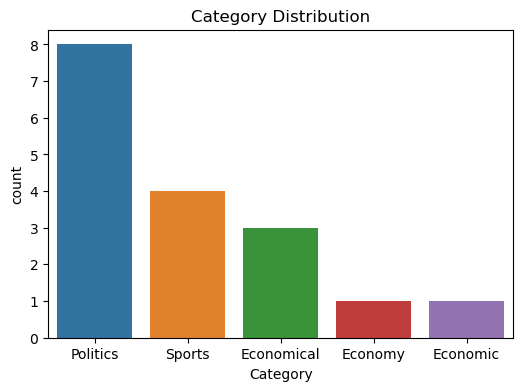

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index)
plt.title('Category Distribution')
plt.show()

# Step 3: Sentiment Distribution

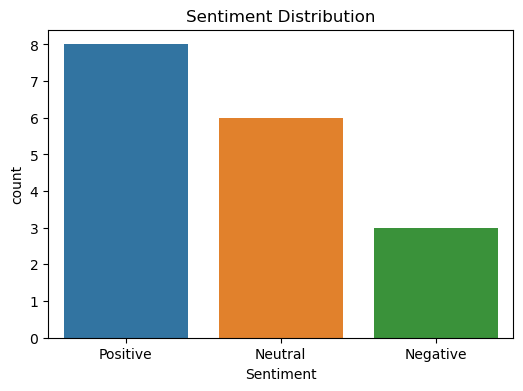

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sentiment', order=df['Sentiment'].value_counts().index)
plt.title('Sentiment Distribution')
plt.show()

# Step 4: Word Cloud for Each Category

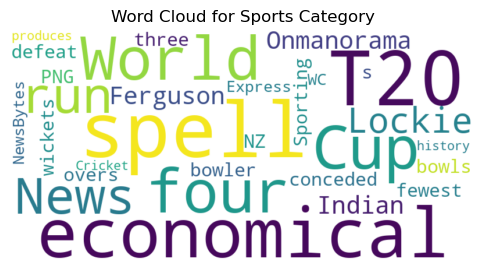

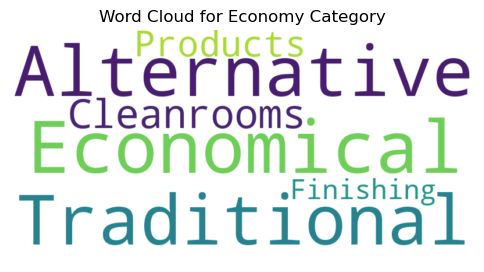

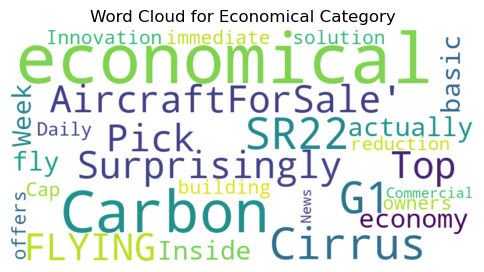

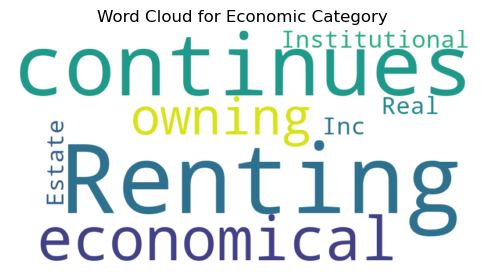

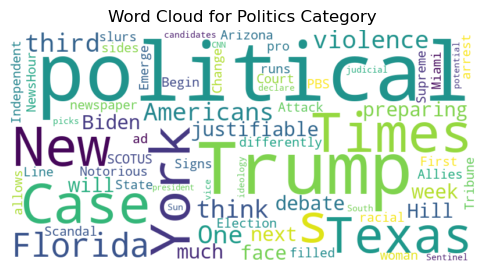

In [8]:

for category in df['Category'].unique():
    subset = df[df['Category'] == category]
    text = ' '.join(subset['News Title'].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category} Category')
    plt.axis('off')
    plt.show()

# Step 5: Title Length Analysis

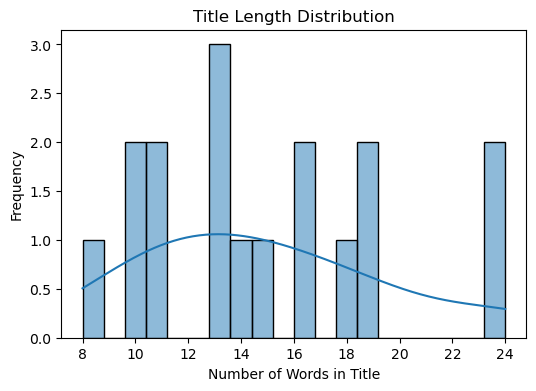

In [9]:
df['title_length'] = df['News Title'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6, 4))
sns.histplot(df['title_length'], bins=20, kde=True)
plt.title('Title Length Distribution')
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency')
plt.show()

# Initialize NLTK resources

In [10]:

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Step 1: Advanced Preprocessing

In [11]:

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [12]:
def preprocess_text(text):
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['processed_title'] = df['News Title'].apply(preprocess_text)

In [13]:
df.head(5)

,News Title,Category,Sentiment,Aspect,title_length,processed_title
0,Most economical spells at T20 World Cup - Whic...,Sports,Neutral,Economy,24,economical spell t20 world cup bowler conceded...
1,"Four overs, three wickets, no run: Lockie Ferg...",Sports,Positive,Achievement,24,four over three wicket run lockie ferguson bow...
2,Economical Alternative to Traditional Cleanroo...,Economy,Positive,Economics,8,economical alternative traditional cleanrooms ...
3,T20 WC: Most economical four-over spells by In...,Sports,Neutral,Cricket,10,t20 wc economical fourover spell indian newsbytes
4,This 2002 Cirrus SR22 G1 Is a Surprisingly Eco...,Economical,Positive,Economy,14,2002 cirrus sr22 g1 surprisingly economical ai...


# Step 2: Encode target variables

In [14]:

label_encoder_category = LabelEncoder()
label_encoder_sentiment = LabelEncoder()

In [15]:
df['category_encoded'] = label_encoder_category.fit_transform(df['Category'])
df['sentiment_encoded'] = label_encoder_sentiment.fit_transform(df['Sentiment'])

In [16]:
df.head(5)

,News Title,Category,Sentiment,Aspect,title_length,processed_title,category_encoded,sentiment_encoded
0,Most economical spells at T20 World Cup - Whic...,Sports,Neutral,Economy,24,economical spell t20 world cup bowler conceded...,4,1
1,"Four overs, three wickets, no run: Lockie Ferg...",Sports,Positive,Achievement,24,four over three wicket run lockie ferguson bow...,4,2
2,Economical Alternative to Traditional Cleanroo...,Economy,Positive,Economics,8,economical alternative traditional cleanrooms ...,2,2
3,T20 WC: Most economical four-over spells by In...,Sports,Neutral,Cricket,10,t20 wc economical fourover spell indian newsbytes,4,1
4,This 2002 Cirrus SR22 G1 Is a Surprisingly Eco...,Economical,Positive,Economy,14,2002 cirrus sr22 g1 surprisingly economical ai...,1,2


# Step 3: Feature Extraction with TF-IDF

In [17]:

vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Including bigrams

# Split data into training and testing sets for category prediction

In [18]:

X = df['processed_title']
y_category = df['category_encoded']
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y_category, test_size=0.2, random_state=42)

# Split data into training and testing sets for sentiment prediction

In [19]:

y_sentiment = df['sentiment_encoded']
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(X, y_sentiment, test_size=0.2, random_state=42)

# Step 4: Model Training and Hyperparameter Tuning for Category Prediction

In [20]:

pipeline_category = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', RandomForestClassifier())
])

param_grid_category = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5, 10]
}

In [21]:
grid_search_category = GridSearchCV(pipeline_category, param_grid_category, cv=3, n_jobs=-1, verbose=1)
grid_search_category.fit(X_train_cat, y_train_cat)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [10, 20, None],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [100, 200]},
             verbose=1)

# Step 5: Model Training and Hyperparameter Tuning for Sentiment Prediction

In [22]:

pipeline_sentiment = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', RandomForestClassifier())
])

In [23]:
param_grid_sentiment = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5, 10]
}

In [24]:
grid_search_sentiment = GridSearchCV(pipeline_sentiment, param_grid_sentiment, cv=3, n_jobs=-1, verbose=1)
grid_search_sentiment.fit(X_train_sent, y_train_sent)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [10, 20, None],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [100, 200]},
             verbose=1)

# Step 6: Evaluation for Category Prediction

In [25]:

y_pred_cat = grid_search_category.predict(X_test_cat)
print("Category Prediction Report:\n", classification_report(y_test_cat, y_pred_cat))

Category Prediction Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           3       0.33      1.00      0.50         1
           4       1.00      0.50      0.67         2

    accuracy                           0.50         4
   macro avg       0.44      0.50      0.39         4
weighted avg       0.58      0.50      0.46         4



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Step 6: Evaluation for Sentiment Prediction

In [26]:

y_pred_sent = grid_search_sentiment.predict(X_test_sent)
print("Sentiment Prediction Report:\n", classification_report(y_test_sent, y_pred_sent))

Sentiment Prediction Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.25      1.00      0.40         1

    accuracy                           0.25         4
   macro avg       0.12      0.50      0.20         4
weighted avg       0.06      0.25      0.10         4



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
def predict_category_sentiment(title):
    processed_title = preprocess_text(title)
    category_encoded = grid_search_category.predict([processed_title])[0]
    sentiment_encoded = grid_search_sentiment.predict([processed_title])[0]
    category = label_encoder_category.inverse_transform([category_encoded])[0]
    sentiment = label_encoder_sentiment.inverse_transform([sentiment_encoded])[0]
    return category, sentiment

# Example prediction

In [28]:

new_title = "Lockie Ferguson produces most economical spell in T20 World Cup history"
predicted_category, predicted_sentiment = predict_category_sentiment(new_title)
print(f"Predicted Category: {predicted_category}, Predicted Sentiment: {predicted_sentiment}")

Predicted Category: Sports, Predicted Sentiment: Positive
